# IMPORTS

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter
import random
import torch
from sklearn.model_selection import train_test_split

# SETTINGS

In [129]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [ ]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name', "release_year"], right_on=['title', 'release_year_new'], how='inner')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "freebase_movie_ID", "title", "status_new","imdb_id",
        "original_language", "original_title","tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
elif SETTINGS["DATA_VERSION"] == 4:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        "names", 
        "date_x", 
        "score", 
        "genre", 
        "overview", 
        "crew", 
        "orig_title", 
        "status", 
        "orig_lang", 
        "budget_x", 
        "revenue", 
        "country"
    ]

    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}imdb_movies.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['names'] = MOVIES_NEW['names'].str.strip().str.lower()
    
        
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['date_x'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name'], right_on=['names'], how='left')
    # MOVIES = MOVIES.drop(columns=[
    #     "id_new", "title", "status_new", "revenue_new", "runtime_new", "imdb_id",
    #     "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
    #     'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    # ])  

MOVIES.head()

C:\Users\mique\AppData\Local\Temp\ipykernel_32796\1470341653.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
C:\Users\mique\AppData\Local\Temp\ipykernel_32796\1470341653.py:91: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new  
0              2001  
1              2000  
2              1913  
3              1938  
4                 0

In [131]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

Wikipedia movie ID Freebase movie ID Movie release date  \
0              975900         /m/03vyhn         2001-08-24   
1              975900         /m/03vyhn         2001-08-24   
2              975900         /m/03vyhn         2001-08-24   
3              975900         /m/03vyhn         2001-08-24   
4              975900         /m/03vyhn         2001-08-24   

               Character name Actor date of birth Actor gender  \
0                    Akooshay          1958-08-26            F   
1  Lieutenant Melanie Ballard          1974-08-15            F   
2         Desolation Williams          1969-06-15            M   
3          Sgt Jericho Butler          1967-09-12            M   
4             Bashira Kincaid          1977-09-25            F   

   Actor height (in meters) Actor ethnicity (Freebase ID)          Actor name  \
0                     1.620                           NaN      Wanda De Jesus   
1                     1.780                    /m/044038p  Natasha Henstridge   
2                     1.727                       /m/0x67            Ice Cube   
3                     1.750                           NaN       Jason Statham   
4                     1.650                           NaN         Clea DuVall   

   Actor age at movie release Freebase character/actor map ID  \
0                        42.0                      /m/0bgchxw   
1                        27.0                       /m/0jys3m   
2                        32.0                       /m/0jys3g   
3                        33.0                      /m/02vchl6   
4                        23.0                      /m/02vbb3r   

  Freebase character ID Freebase actor ID  
0            /m/0bgcj3x        /m/03wcfv7  
1            /m/0bgchn4         /m/0346l4  
2            /m/0bgchn_        /m/01vw26l  
3            /m/0bgchnq         /m/034hyc  
4            /m/0bgchp9         /m/01y9xg

In [132]:
column_names = [
    "wikipedia_movie_ID",
    "plot"
]

PLOTS = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}plot_summaries.txt', sep='\t', header=None, encoding='utf-8', names=column_names)
MOVIES = pd.merge(MOVIES, PLOTS, on="wikipedia_movie_ID", how="left")

MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new                                               plot  
0              2001  Set in the second half of the 22nd century, th...  
1              2000                                                NaN  
2              1913                                                NaN  
3              1938                                                NaN  
4                 0                                                NaN

In [133]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'release_date_new', 'revenue_new', 'runtime_new', 'adult',
       'budget', 'overview', 'popularity', 'release_year_new', 'plot'],
      dtype='object')

### Duplicated columns

In [134]:
len(MOVIES["wikipedia_movie_ID"]) - len(MOVIES["wikipedia_movie_ID"].unique())

6023

In [135]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head()

wikipedia_movie_ID    name release_date  revenue  runtime  \
3039            37283373  island          NaN      NaN      NaN   
3040            37283373  island          NaN      NaN      NaN   
3035            37283373  island          NaN      NaN      NaN   
3036            37283373  island          NaN      NaN      NaN   
3037            37283373  island          NaN      NaN      NaN   

                               languages countries                     genres  \
3039  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3040  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3035  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3036  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   
3037  {"/m/02h40lc": "English Language"}        {}  {"/m/01drsx": "Disaster"}   

      release_year vote_average vote_count release_date_new revenue_new  \
3039             0          0.0          0              NaN           0   
3040             0          0.0          0              NaN           0   
3035             0          0.0          0              NaN           0   
3036             0          0.0          0              NaN           0   
3037             0          0.0          0              NaN           0   

     runtime_new  adult budget  \
3039           4  False      0   
3040           0  False      0   
3035           0  False      0   
3036          13  False      0   
3037           4  False      0   

                                               overview popularity  \
3039  An immigrant in Italy, away from his family wh...        0.6   
3040  A maritime warden investigates an unauthorised...        0.6   
3035          A man lost at sea washes up on an island.        0.6   
3036                                    a short film by        0.6   
3037  A music video by Eli Hayes for Geomi’s track, ...        0.0   

      release_year_new                                               plot  
3039                 0  A Czech-born woman arrives on a Greek island h...  
3040                 0  A Czech-born woman arrives on a Greek island h...  
3035                 0  A Czech-born woman arrives on a Greek island h...  
3036                 0  A Czech-born woman arrives on a Greek island h...  
3037                 0  A Czech-born woman arrives on a Greek island h...

In [136]:
MOVIES.isna().sum()

wikipedia_movie_ID        0
name                      0
release_date           1503
revenue               33109
runtime                6809
languages                 0
countries                 0
genres                    0
release_year              0
vote_average              0
vote_count                0
release_date_new       9951
revenue_new               0
runtime_new               0
adult                     0
budget                    0
overview               2508
popularity                0
release_year_new          0
plot                  15879
dtype: int64

As we can see there are some missing values and duplicated movies...
Lets do some ✨magic✨
### Remove duplicates

In [137]:
#get duplicated movies of MOVIES df
dupes = MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False)
#keep highest value in columns: 
for col in ['release_year','revenue', 'runtime', 'runtime_new', 'budget', 'popularity', 'revenue_new', 'release_date_new', 'adult' ]:
    dupes[col] = pd.to_numeric(dupes[col], errors='coerce').astype('float64')
    new = dupes.groupby('wikipedia_movie_ID')[col].transform('max')
    dupes[col] = new
dupes['adult'] = dupes['adult'].astype('bool')

#keep longest plot
dupes['plot'] = dupes['plot'].astype('str')
dupes['len_plot'] = dupes['plot'].apply(len)
max_len_idx = dupes.groupby('wikipedia_movie_ID')['len_plot'].idxmax()
dupes['plot'] = dupes['wikipedia_movie_ID'].map(dupes.loc[max_len_idx].set_index('wikipedia_movie_ID')['plot'])

#keep vote avg and count of movie with highest vote count
dupes['vote_count'] = pd.to_numeric(dupes['vote_count'], errors='coerce').astype('float64')
max_len_idx = dupes.groupby('wikipedia_movie_ID')['vote_count'].idxmax()
dupes['vote_average'] = dupes['wikipedia_movie_ID'].map(dupes.loc[max_len_idx].set_index('wikipedia_movie_ID')['vote_average'])
dupes['vote_count'] = dupes.groupby('wikipedia_movie_ID')['vote_count'].transform('max')

#list of the movies that had been duplicated, with the final parameters
unduped = dupes.drop_duplicates(subset=['wikipedia_movie_ID'], keep='first')


In [138]:
#remove the duplicates from MOVIES and insert the correct movies from unduped 
MOVIES = MOVIES[~MOVIES.index.isin(dupes.index)]
#MOVIES = pd.merge(MOVIES, unduped, on='wikipedia_movie_ID', how='outer')
MOVIES = pd.concat([MOVIES, unduped], ignore_index=True)

len(MOVIES)-len(MOVIES["wikipedia_movie_ID"].unique())


0

# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Recover information from the new dataset if it was missing in the original

In [139]:
MOVIES['runtime'] = MOVIES['runtime'].combine_first(MOVIES['runtime_new'])
MOVIES['revenue'] = MOVIES['revenue'].combine_first(MOVIES['revenue_new'])
MOVIES['plot'] = MOVIES['plot'].combine_first(MOVIES['overview'])

### Release date to year

In [140]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

# if "release_date" in MOVIES.columns:
#     MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
if MOVIES["release_year"].dtype == "int64":
    MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]

print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894.0, Last year: 2016.0


0        2001.0
1        2000.0
2        1913.0
3        1938.0
5        1997.0
          ...  
33938    1976.0
33939    1960.0
33941    1992.0
33942    1976.0
33943    1989.0
Name: release_year, Length: 29447, dtype: float64

### Parse features to actual numbers

In [141]:
MOVIES["budget"] = MOVIES["budget"].astype(float)
MOVIES["popularity"] = MOVIES["popularity"].astype(float)
MOVIES["revenue"] = MOVIES["revenue"].astype(float)
MOVIES["runtime"] = MOVIES["runtime"].astype(float)
MOVIES["vote_average"] = MOVIES["vote_average"].astype(float)
MOVIES["vote_count"] = MOVIES["vote_count"].astype(float)
#MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]
MOVIES["adult"] = MOVIES["adult"].apply(lambda x: 1 if x == "True" else 0)
MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
5             6631279                                        little city   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         0.0     95.0   
2   1913-05-29         0.0     35.0   
3   1938-08-16   3600000.0    106.0   
5   1997-04-04         0.0     93.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
5                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
5  {"/m/09c7w0": "United States of America"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...        2001.0   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...        2000.0   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...        1913.0   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...        1938.0   
5  {"/m/06cvj": "Romantic comedy", "/m/0hj3n0w": ...        1997.0   

   vote_average  ...  release_date_new revenue_new runtime_new adult  \
0         5.127  ...        2001-08-24    14010832          98     0   
1         0.000  ...        2000-02-16           0          60     0   
2         6.000  ...        1913-05-29           0          35     0   
3         6.600  ...        1938-05-24     4000000         106     0   
5         3.833  ...        1997-04-04           0          90     0   

       budget                                           overview popularity  \
0  28000000.0  In 2176, a Martian police unit is sent to pick...     14.189   
1         0.0  Dramatization of the story behind the murder o...      0.600   
2         0.0  An amusing burlesque of gang fighters. The pol...      0.600   
3   2000000.0  Classical violinist, Roger Grant disappoints h...      2.522   
5         0.0  Best friends Adam and Kevin have a lot in comm...      1.556   

   release_year_new                                               plot  \
0              2001  Set in the second half of the 22nd century, th...   
1              2000  Dramatization of the story behind the murder o...   
2              1913  An amusing burlesque of gang fighters. The pol...   
3              1938  Classical violinist, Roger Grant disappoints h...   
5              1997  Adam, a San Francisco-based artist who works a...   

  len_plot  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
5      NaN  

[5 rows x 21 columns]

### Gather sub-genre into general genre

In [142]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

categories                                          subgenres
0  Action/Adventure  [Action, Adventure, Action/Adventure, Martial ...
1        Adaptation     [Film adaptation, Remake, Live action, Reboot]
2             Adult  [Sex comedy, Erotica, Erotic thriller, Pornogr...
3         Animation  [Animation, Anime, Computer Animation, Clay an...
4      Asian Movies  [Bollywood, Filipino Movies, Chinese Movies, J...

In [143]:
def get_hot_genre(genre):
    new_genre = []
    genre_hot = []
    
    movie_genre = set(genre)
    
    for _, row in NEW_GENRE.iterrows():
        sub_genres = set(row["subgenres"])
        if bool(movie_genre & sub_genres):
            new_genre.append(row["categories"])
            genre_hot.append(1)
        else: genre_hot.append(0)
    
    return new_genre, genre_hot


In [144]:
MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))

In [145]:
MOVIES[["original_genres", "new_genres", "genre_hot"]].head()

original_genres  \
0  (Thriller, Science Fiction, Horror, Adventure,...   
1   (Mystery, Biographical film, Drama, Crime Drama)   
2  (Short Film, Silent film, Indie, Black-and-whi...   
3                 (Musical, Comedy, Black-and-white)   
5  (Romantic comedy, Ensemble Film, Comedy-drama,...   

                                          new_genres  \
0  [Action/Adventure, Horror, Science Fiction, Su...   
1  [Crime, Drama, Mystery/Suspense, Non-fiction/E...   
2  [Comedy, Indie, Old-fashioned/classical style,...   
3  [Comedy, Music/Dance, Old-fashioned/classical ...   
5                    [Comedy, Drama, Romance, Other]   

                                           genre_hot  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...

### Remove movies without plot

In [146]:
MOVIES = MOVIES[MOVIES["plot"].notna()]

### Clean not anymore usefull columns

In [147]:
MOVIES = MOVIES.drop(columns=[
    "release_date_new", "revenue_new", "runtime_new", "overview", "release_year_new", "len_plot"
])    

In [148]:
print(f"We end up with: {len(MOVIES)} movies")
MOVIES.isna().sum()

We end up with: 29017 movies


wikipedia_movie_ID    0
name                  0
release_date          0
revenue               0
runtime               0
languages             0
countries             0
genres                0
release_year          0
vote_average          0
vote_count            0
adult                 0
budget                0
popularity            0
plot                  0
original_genres       0
new_genres            0
genre_hot             0
dtype: int64

As we can see we've lost a lot of movies. The majority of them originally had very little information.

Using the new dataset we got back some of that information. And better, now we are going to enrich MORE what we have:

# DATA EXPANSION
### Get the "theme" features for each movie

In [149]:
from theme_encoding import theme_encoding

column_names = ["death", "love", "tragedy"]
#This is demontration purpose. More keywords will added later.
matrix_themes = pd.DataFrame(theme_encoding(MOVIES['plot']),  columns=column_names)

MOVIES.reset_index(inplace=True, drop=True)
MOVIES[column_names] = matrix_themes
MOVIES[column_names]

death      love   tragedy
0      0.500000  0.100000  0.400000
1      1.000000  0.000000  0.000000
2      0.000000  0.000000  0.000000
3      0.000000  0.800000  0.200000
4      0.200000  0.600000  0.200000
...         ...       ...       ...
29012  0.187500  0.562500  0.250000
29013  0.571429  0.428571  0.000000
29014  0.562500  0.375000  0.062500
29015  0.333333  0.666667  0.000000
29016  0.476190  0.190476  0.333333

[29017 rows x 3 columns]

### Sentiment analysis of the plot

In [150]:
MOVIES['sentiment'] = MOVIES['plot'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)

MOVIES['sentiment'].head()

0   -0.085095
1   -0.050000
2    0.600000
3    0.441667
4    0.165202
Name: sentiment, dtype: float64

### Character analysis

In [151]:
# Step 1: Count total characters for each movie in the CHARACTER DataFrame, including any potential missing entries
total_character_counts = CHARACTER.groupby('Wikipedia movie ID').size().reset_index(name='Character Count')

# Step 2: Drop existing 'Character Count' column in MOVIES if it exists to avoid conflict during the merge
if 'Character Count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Character Count'])

# Step 3: Rename the 'Wikipedia movie ID' column in `total_character_counts` to avoid conflicts during merging
#total_character_counts = total_character_counts.rename(columns={'Wikipedia movie ID': 'movie_id_temp'})

# Step 4: Merge this data into MOVIES based on Wikipedia movie ID, filling missing values with 0
#MOVIES = MOVIES.merge(total_character_counts, left_on='wikipedia_movie_ID', right_on='movie_id_temp', how='left')
MOVIES = MOVIES.merge(total_character_counts, left_on='wikipedia_movie_ID', right_on='Wikipedia movie ID', how='left')
MOVIES['Character Count'] = MOVIES['Character Count'].fillna(0).astype(int)
MOVIES['Character Count'] = MOVIES['Character Count'].astype(int)

if 'Wikipedia movie ID' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

MOVIES["Character Count"]

0        17
1        15
2         1
3         4
4         6
         ..
29012    11
29013     6
29014    12
29015    11
29016    10
Name: Character Count, Length: 29017, dtype: int32

In [152]:
# Step 1: Create a helper column for counting NaN values in "Actor gender"
CHARACTER['Actor gender filled'] = CHARACTER['Actor gender'].fillna('N/A')

# Step 2: Use pivot_table to count occurrences of each gender per Wikipedia movie ID
actor_counts = CHARACTER.pivot_table(
    index='Wikipedia movie ID',
    columns='Actor gender filled',
    aggfunc='size',
    fill_value=0
).reset_index()

# Step 3: Rename columns for clarity
actor_counts = actor_counts.rename(columns={
    'M': 'Male actor count',
    'F': 'Female actor count',
    'N/A': 'N/A actor count'
})

# Display the resulting DataFrame
actor_counts.head()

Actor gender filled  Wikipedia movie ID  Female actor count  Male actor count  \
0                                   330                   4                 0   
1                                  3217                   3                10   
2                                  3333                   6                 8   
3                                  3746                   3                11   
4                                  3837                   2                18   

Actor gender filled  N/A actor count  
0                                  0  
1                                  1  
2                                  0  
3                                  1  
4                                  0

In [153]:
# Step 3: Count male and female characters per movie based on `Wikipedia movie ID`
#gender_counts = CHARACTER.groupby(['Wikipedia movie ID', 'Actor gender']).size().unstack(fill_value=0)

if 'Male actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Male actor count'])
if 'Female actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Female actor count'])
if 'N/A actor count' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['N/A actor count'])

# Rename columns to more meaningful names
#gender_counts.columns = ['Number of Female', 'Number of Male']

#gender_counts

# Step 4: Merge gender counts data back into the MOVIES DataFrame
MOVIES = MOVIES.merge(actor_counts, left_on='wikipedia_movie_ID', right_on='Wikipedia movie ID', how='left')

MOVIES['Male actor count'] = MOVIES['Male actor count'].fillna(0).astype(int)
MOVIES['Female actor count'] = MOVIES['Female actor count'].fillna(0).astype(int)
MOVIES['N/A actor count'] = MOVIES['N/A actor count'].fillna(0).astype(int)

if 'Wikipedia movie ID' in MOVIES.columns:
    MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

# Step 5: Replace NaN values with 0 for movies with no female or male counts
#MOVIES['Number of Female'] = MOVIES['Number of Female'].fillna(0).astype(int)
#MOVIES['Number of Male'] = MOVIES['Number of Male'].fillna(0).astype(int)
#MOVIES['Number with no gender'] = MOVIES['Character Count']- MOVIES['Number of Female'] - MOVIES['Number of Male']  

# Step 7: Drop the extra 'Wikipedia movie ID' column from the merge, if not needed
#MOVIES = MOVIES.drop(columns=['Wikipedia movie ID'])

# Display the updated MOVIES DataFrame with the new columns
MOVIES[["Male actor count", "Female actor count", "N/A actor count"]].head()

Male actor count  Female actor count  N/A actor count
0                11                   6                0
1                11                   4                0
2                 1                   0                0
3                 2                   2                0
4                 2                   4                0

In [154]:
# Étape 1 : Créer une nouvelle colonne 'age_range' dans CHARACTER pour catégoriser les âges
def categorize_age(age):
    if age < 20:
        return '0-20'
    elif 20 <= age < 30:
        return '20-30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 60:
        return '40-60'
    else:
        return '60+'

column_names = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']

# Appliquer la fonction de catégorisation d'âge
CHARACTER['age_range'] = CHARACTER['Actor age at movie release'].apply(categorize_age)

# Étape 2 : Compter le nombre d'acteurs par tranche d'âge pour chaque film
age_counts = CHARACTER.groupby(['Wikipedia movie ID', 'age_range']).size().unstack(fill_value=0)

# Renommer les colonnes pour correspondre aux tranches d'âge
age_counts.columns = column_names

# Étape 3 : Fusionner les données de comptage d'âge avec le DataFrame MOVIES
if column_names[0] not in MOVIES.columns:
    MOVIES = MOVIES.merge(age_counts, left_on='wikipedia_movie_ID', right_index=True, how='left')

# Remplir les valeurs NaN avec 0 pour les films qui n'ont pas d'acteurs dans certaines tranches d'âge
MOVIES[column_names] = MOVIES[column_names].fillna(0).astype(int)

MOVIES[column_names].head()

Actors 0-20  Actors 20-30  Actors 30-40  Actors 40-60  Actors 60+
0            0             2             3             7           5
1            1             0             1             6           7
2            0             0             0             0           1
3            0             2             2             0           0
4            0             1             4             1           0

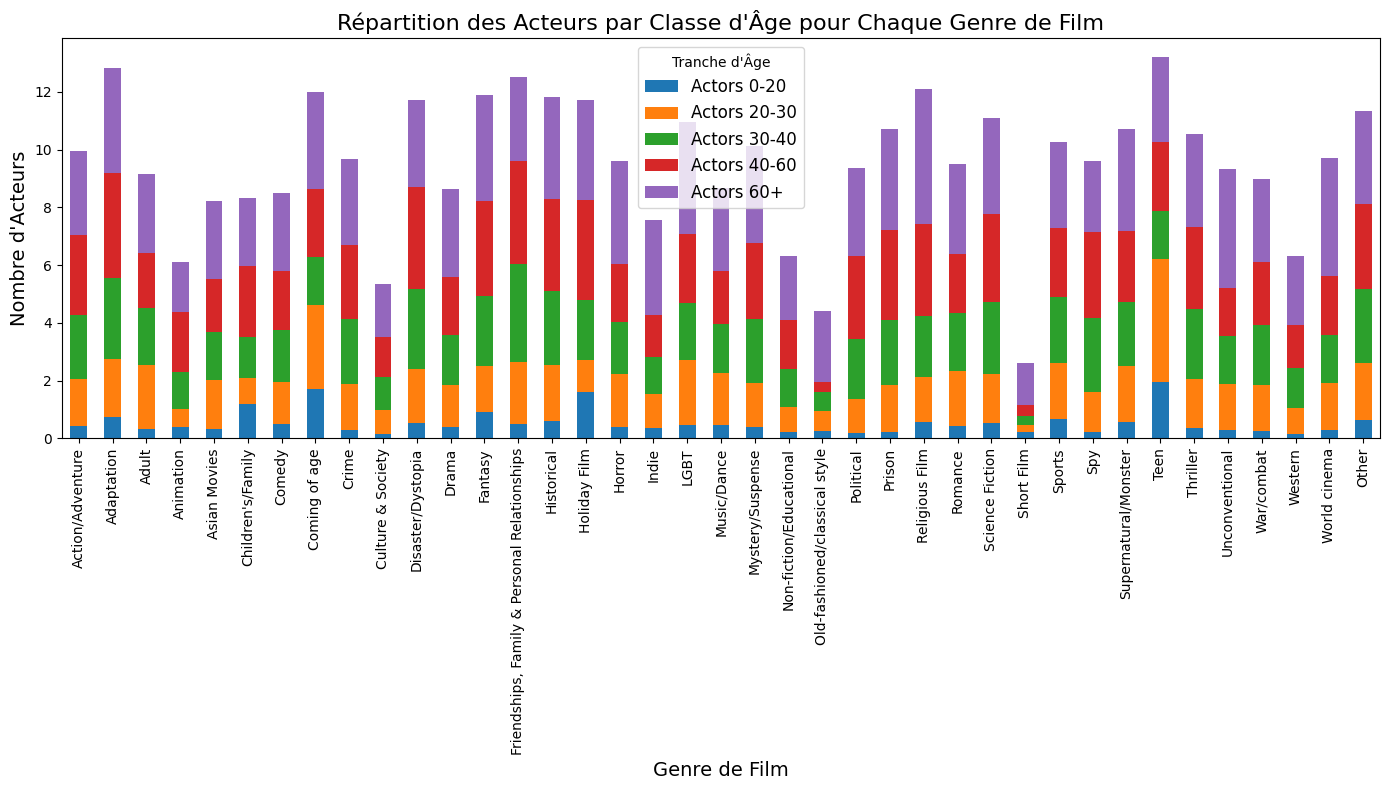

In [155]:
column_names = ['Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+']
plot_df = pd.DataFrame(columns=column_names  + ['genre'])
for _, genre in enumerate(NEW_GENRE["categories"]):
    filtered_df = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    plot_df.loc[len(plot_df)] = filtered_df[column_names].mean()
    
plot_df["genre"] = NEW_GENRE["categories"]
plot_df.set_index('genre', inplace=True)    


plot_df.plot(kind='bar', stacked=True, figsize=(14, 8))

# Ajouter des titres et labels
plt.title("Répartition des Acteurs par Classe d'Âge pour Chaque Genre de Film", fontsize=16)
plt.xlabel("Genre de Film", fontsize=14)
plt.ylabel("Nombre d'Acteurs", fontsize=14)
plt.legend(title="Tranche d'Âge", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()


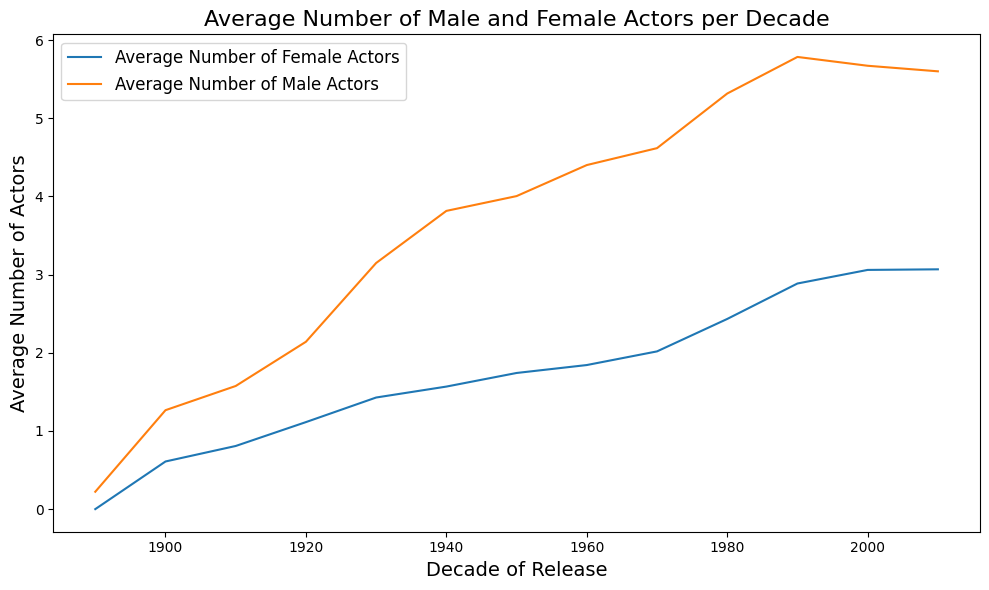

In [156]:
# Step 2: Convert the release year to the corresponding decade
span_of_years = 10
MOVIES['release_decade'] = (MOVIES['release_year'] // span_of_years) * span_of_years

# Step 3: Group by release decade and calculate the average number of male and female actors
average_actors_by_decade = MOVIES.groupby('release_decade')[['Female actor count', 'Male actor count']].mean()

# Step 4: Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average number of male and female actors by decade
average_actors_by_decade.plot(ax=ax)

# Customize the plot with title and labels
ax.set_title("Average Number of Male and Female Actors per Decade", fontsize=16)
ax.set_xlabel("Decade of Release", fontsize=14)
ax.set_ylabel("Average Number of Actors", fontsize=14)
ax.legend(["Average Number of Female Actors", "Average Number of Male Actors"], fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


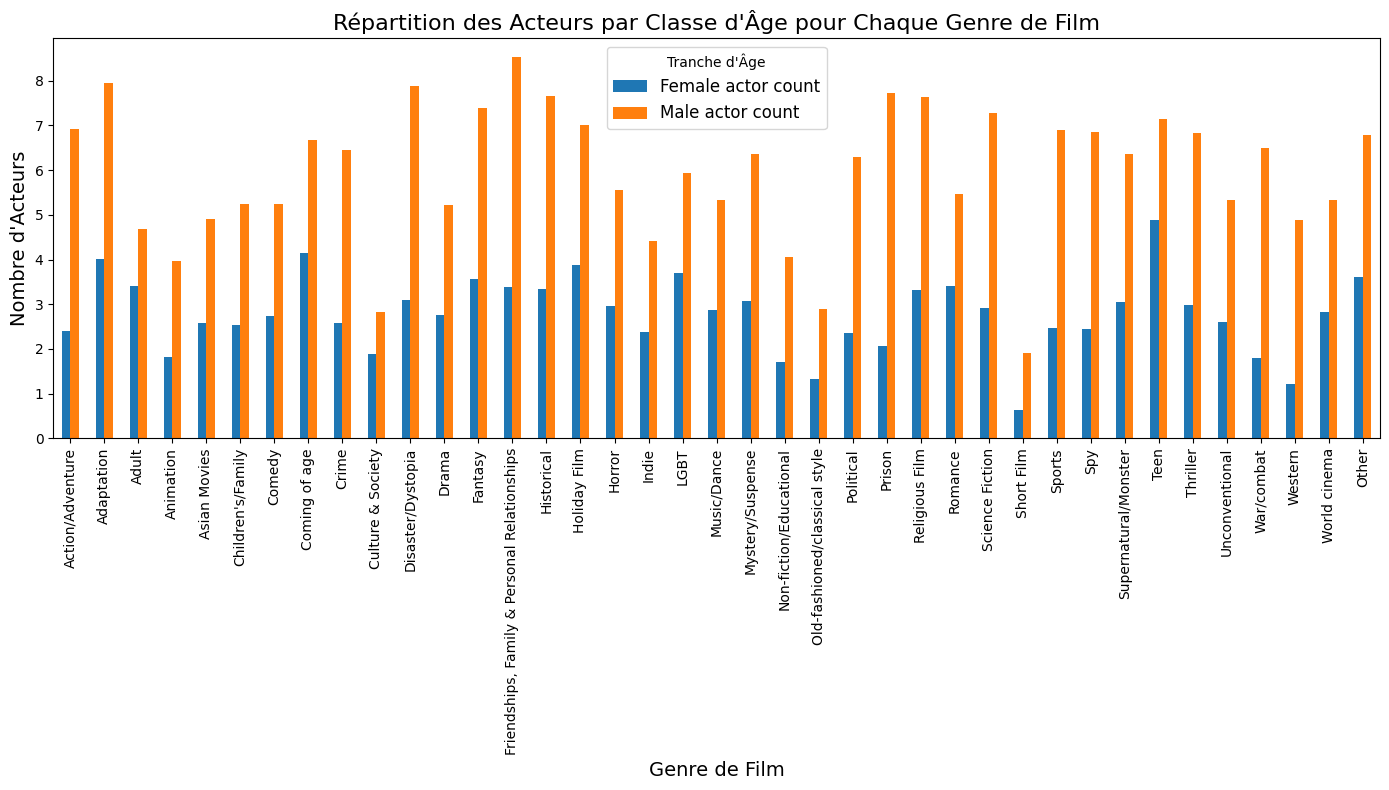

In [157]:
column_names = ['Female actor count', 'Male actor count']
plot_df = pd.DataFrame(columns=column_names + ['genre'])
for _, genre in enumerate(NEW_GENRE["categories"]):
    filtered_df = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    plot_df.loc[len(plot_df)] = filtered_df[column_names].mean()
    
plot_df["genre"] = NEW_GENRE["categories"]
plot_df.set_index('genre', inplace=True)


plot_df.plot(kind='bar', figsize=(14, 8))

# Ajouter des titres et labels
plt.title("Répartition des Acteurs par Classe d'Âge pour Chaque Genre de Film", fontsize=16)
plt.xlabel("Genre de Film", fontsize=14)
plt.ylabel("Nombre d'Acteurs", fontsize=14)
plt.legend(title="Tranche d'Âge", fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()


# Data analysis

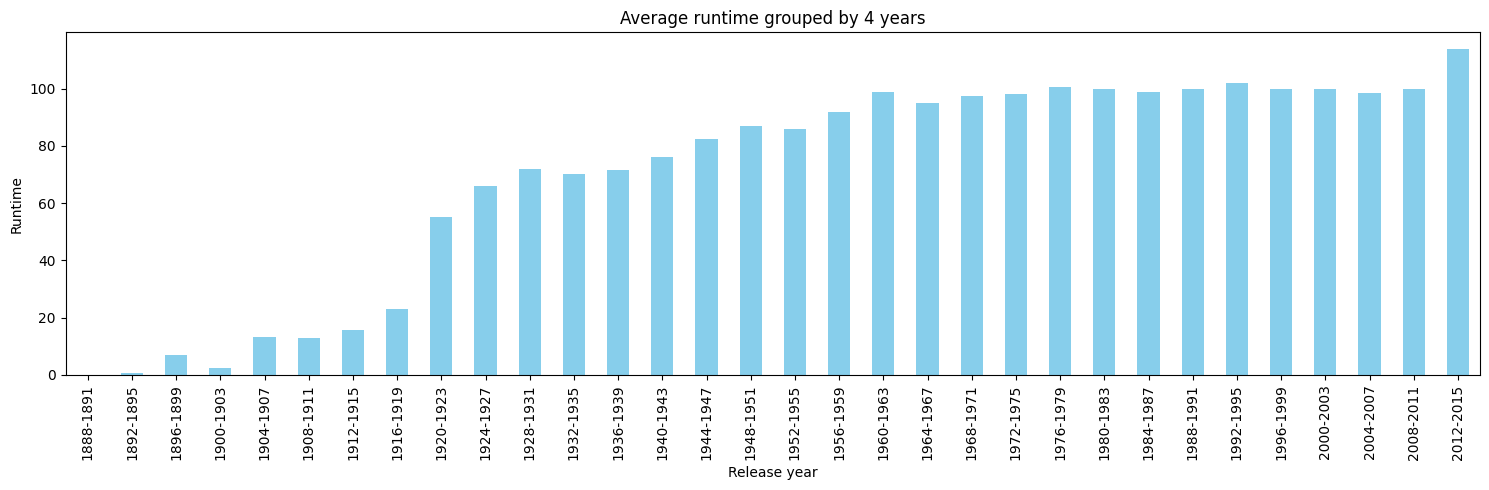

In [158]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4
binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre runtime analysis

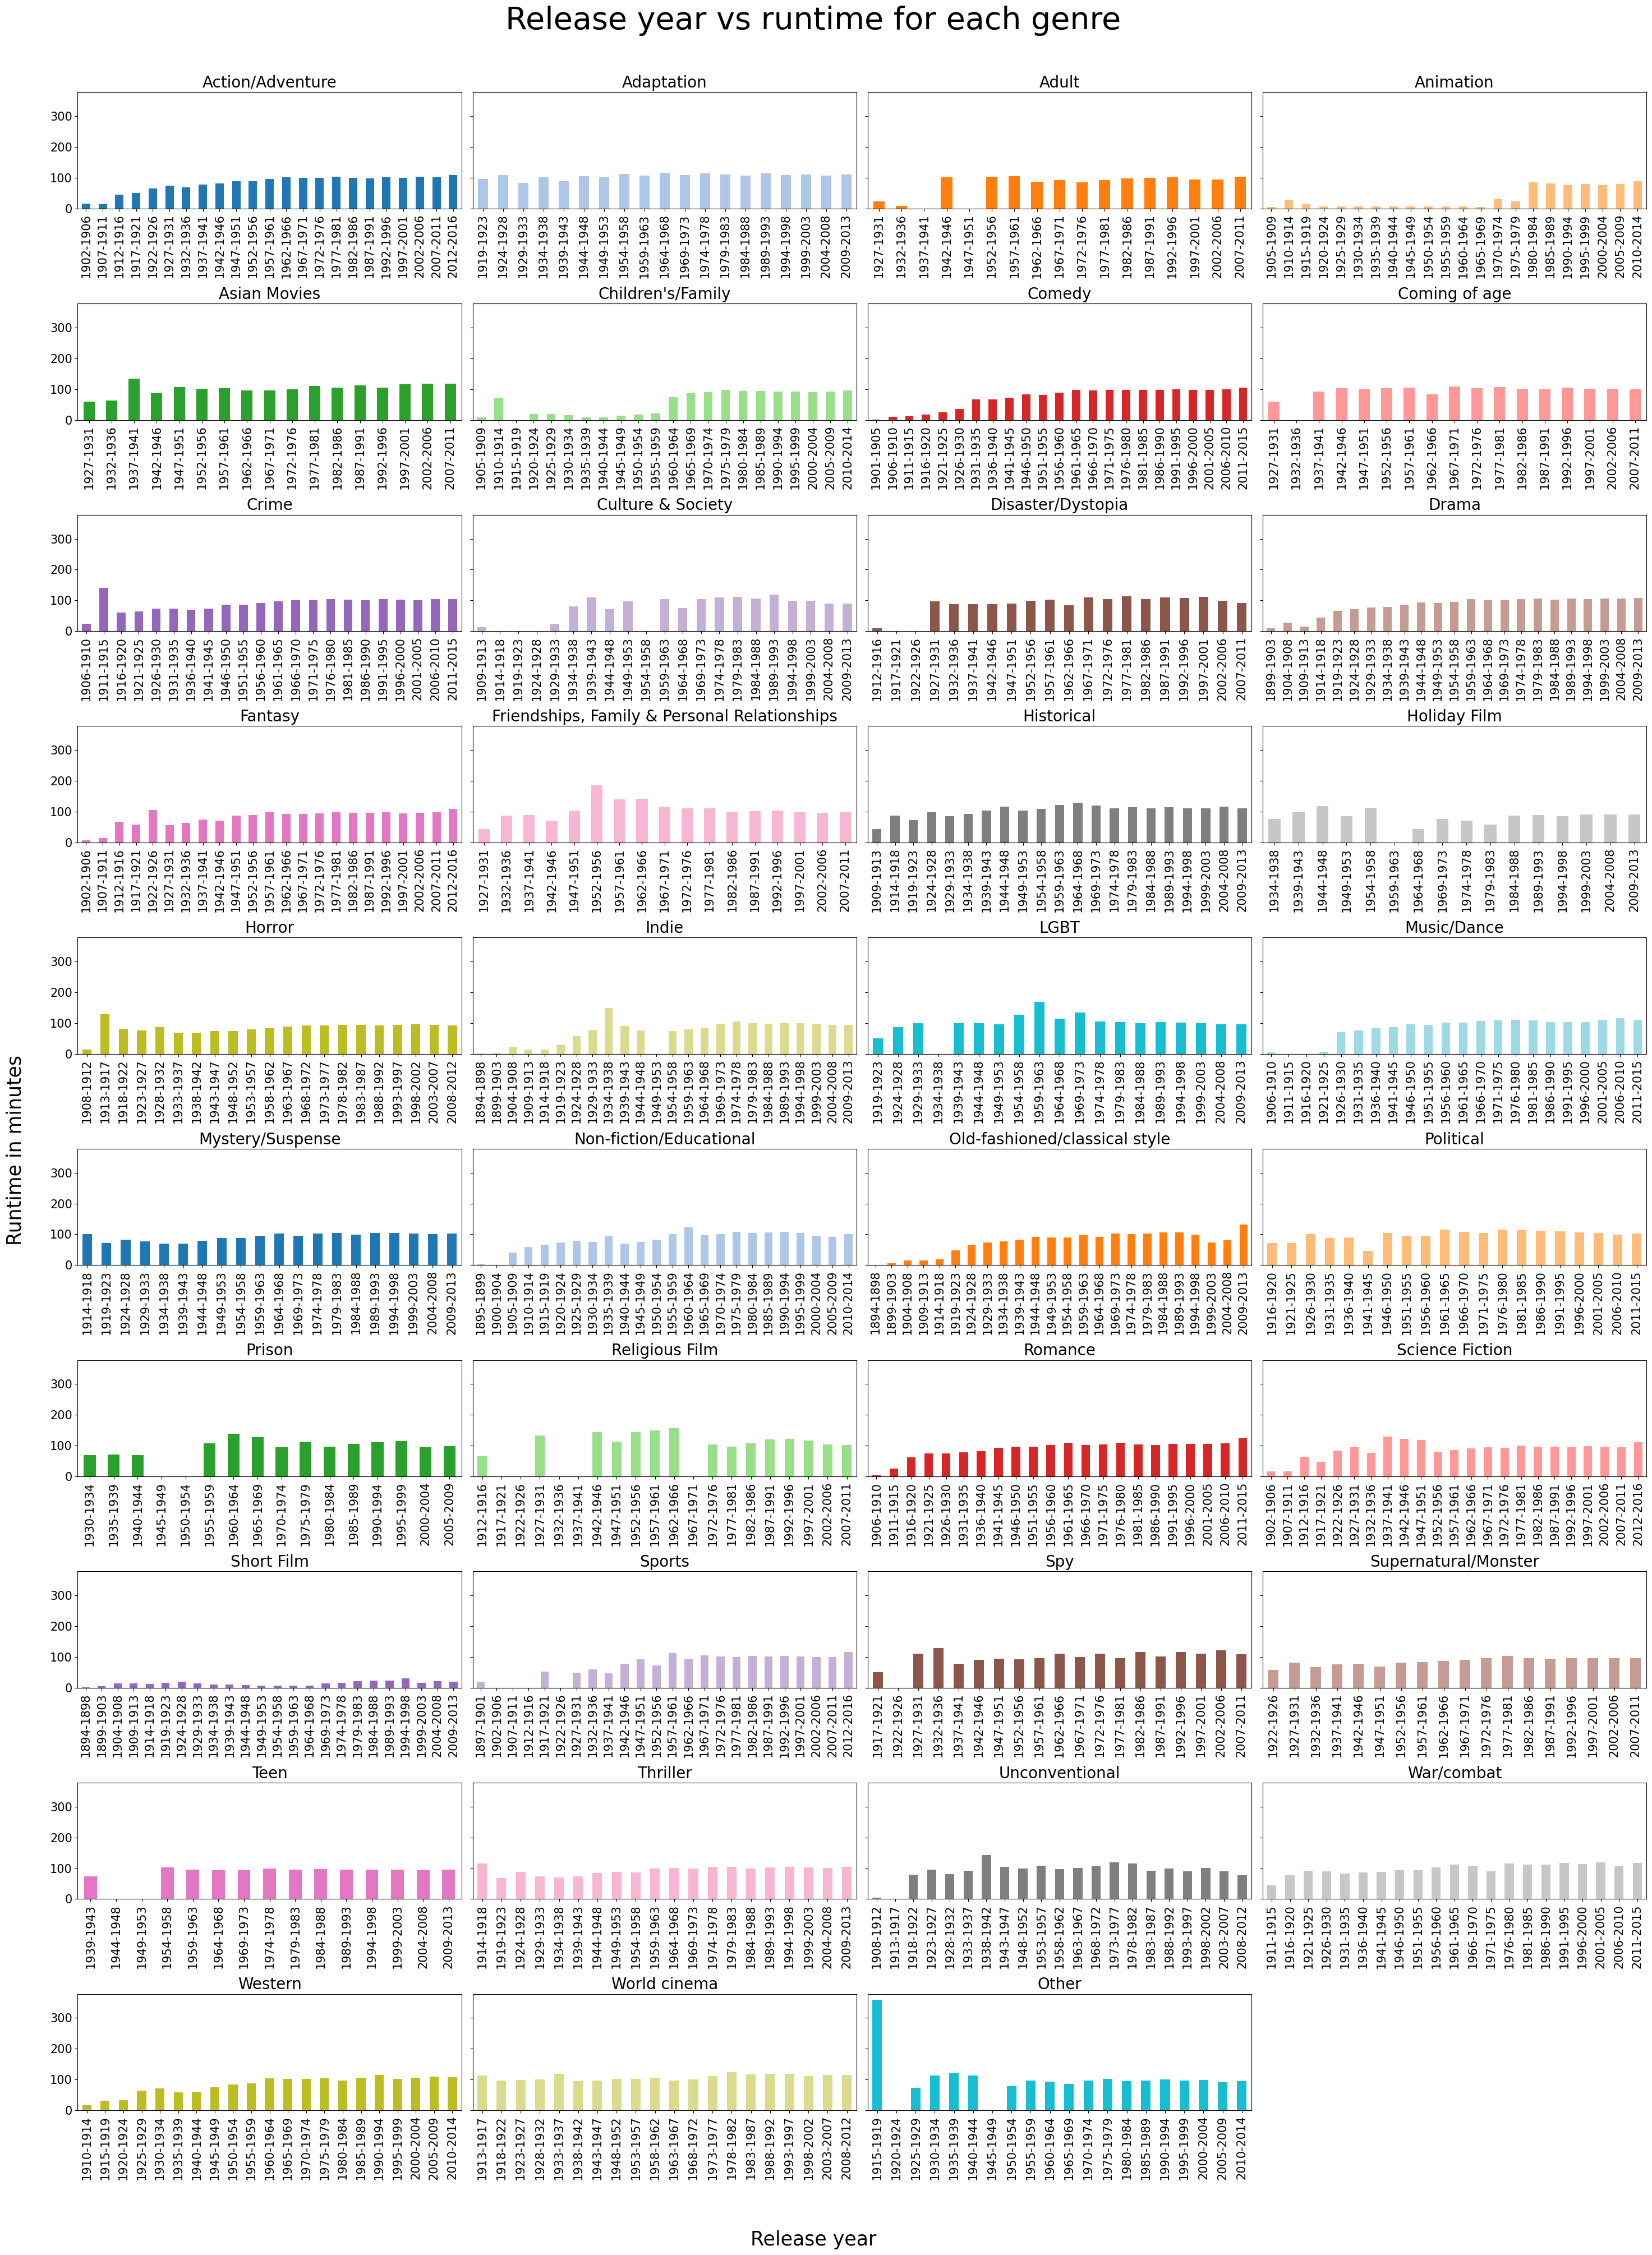

In [159]:
# Bar plot of change in runtime over years for each genre
unique_genre = NEW_GENRE["categories"]

fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
fig.delaxes(axes[9, 3])

#colors
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    # Make bins for interval of years to plot as bars
    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    bin_size = 5
    movies_year_runtime = df_filtered.groupby("release_year")["runtime"].median()
    binned_counts = {}
    for i in range(int(movies_year_runtime.index.min()), int(movies_year_runtime.index.max()), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j//4, j%4]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)
    ax.set_title(genre, size = 20)

fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime in minutes', size = 25)
fig.suptitle('Release year vs runtime for each genre', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Text(0.5, 1.0, 'Genre vs runtime')

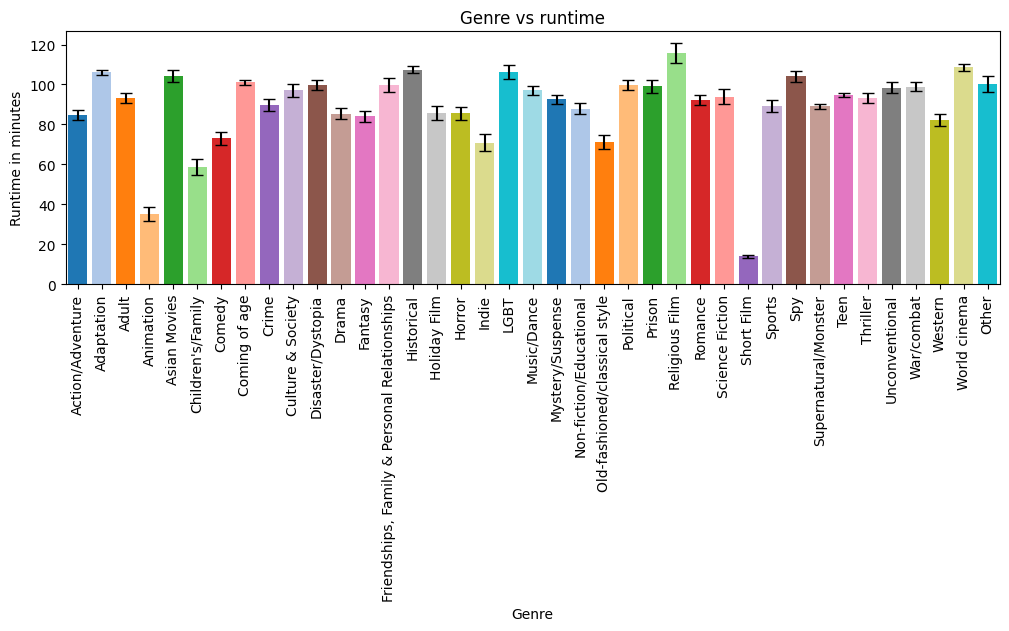

In [160]:
#Runtime average over median each year, with sem errorbars
unique_genre = NEW_GENRE["categories"]
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

average = []
sem = []

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    medians = df_filtered.groupby("release_year")["runtime"].median()
    average.append(medians.mean())
    sem.append(medians.std()/np.sqrt(medians.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(unique_genre[i], average[i], color=color)
    ax.errorbar(unique_genre[i], average[i], yerr=sem[i],capsize=4,  color = 'k')
    
ax.set_xlim(-0.5, len(unique_genre) - 0.5) # Set limits to avoid extra space on sides
plt.tight_layout()
ax.set_xlabel("Genre")
ax.set_ylabel("Runtime in minutes")
ax.set_title("Genre vs runtime")

### Genre revenue analysis

Text(0.5, 1.0, 'Genre vs revenue')

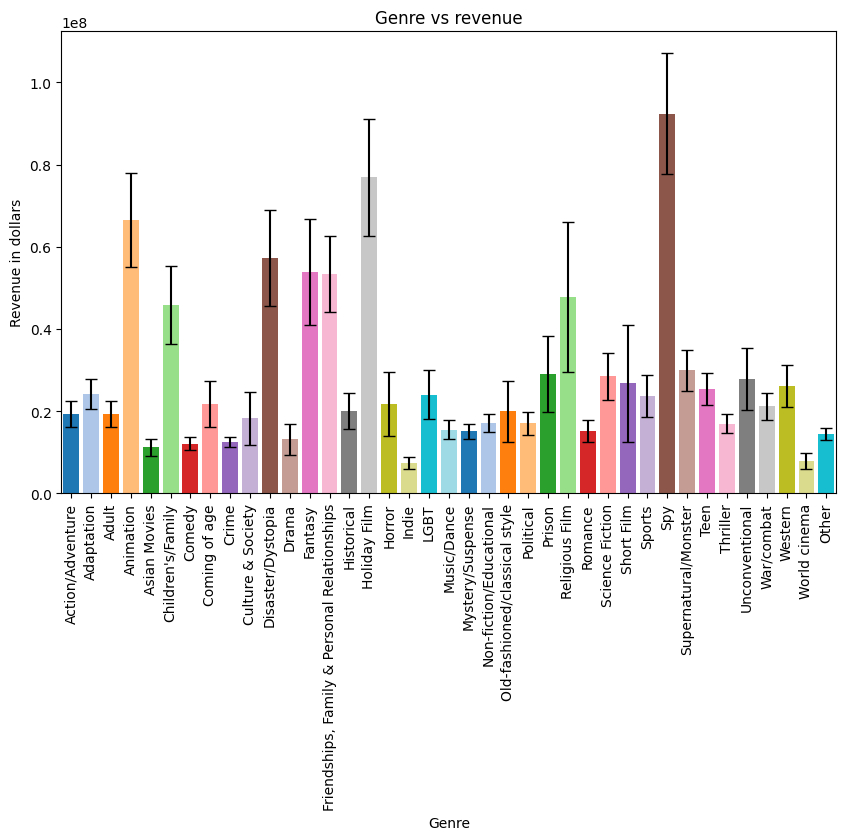

In [161]:
#Genre vs mean of median revenue per year
unique_genre = NEW_GENRE["categories"]

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

average = []
std = []

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered = df_filtered[df_filtered['revenue'] != 0] #We remove 0 revenue movie, as the lowest recorded box office is 11$ according to Wikipedia
    group =  df_filtered.groupby("release_year")["revenue"].median()
    average.append(group.mean())
    std.append(group.std()/np.sqrt(group.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(unique_genre[i], average[i], color=color)
    ax.errorbar(unique_genre[i], average[i], yerr=std[i],capsize=4,  color = 'k')

ax.set_xlim(-0.5, len(unique_genre) - 0.5) # Set limits to avoid extra space on sides
ax.set_xlabel("Genre")
ax.set_ylabel("Revenue in dollars")
ax.set_title("Genre vs revenue")

### Genre and length of synopsis analysis

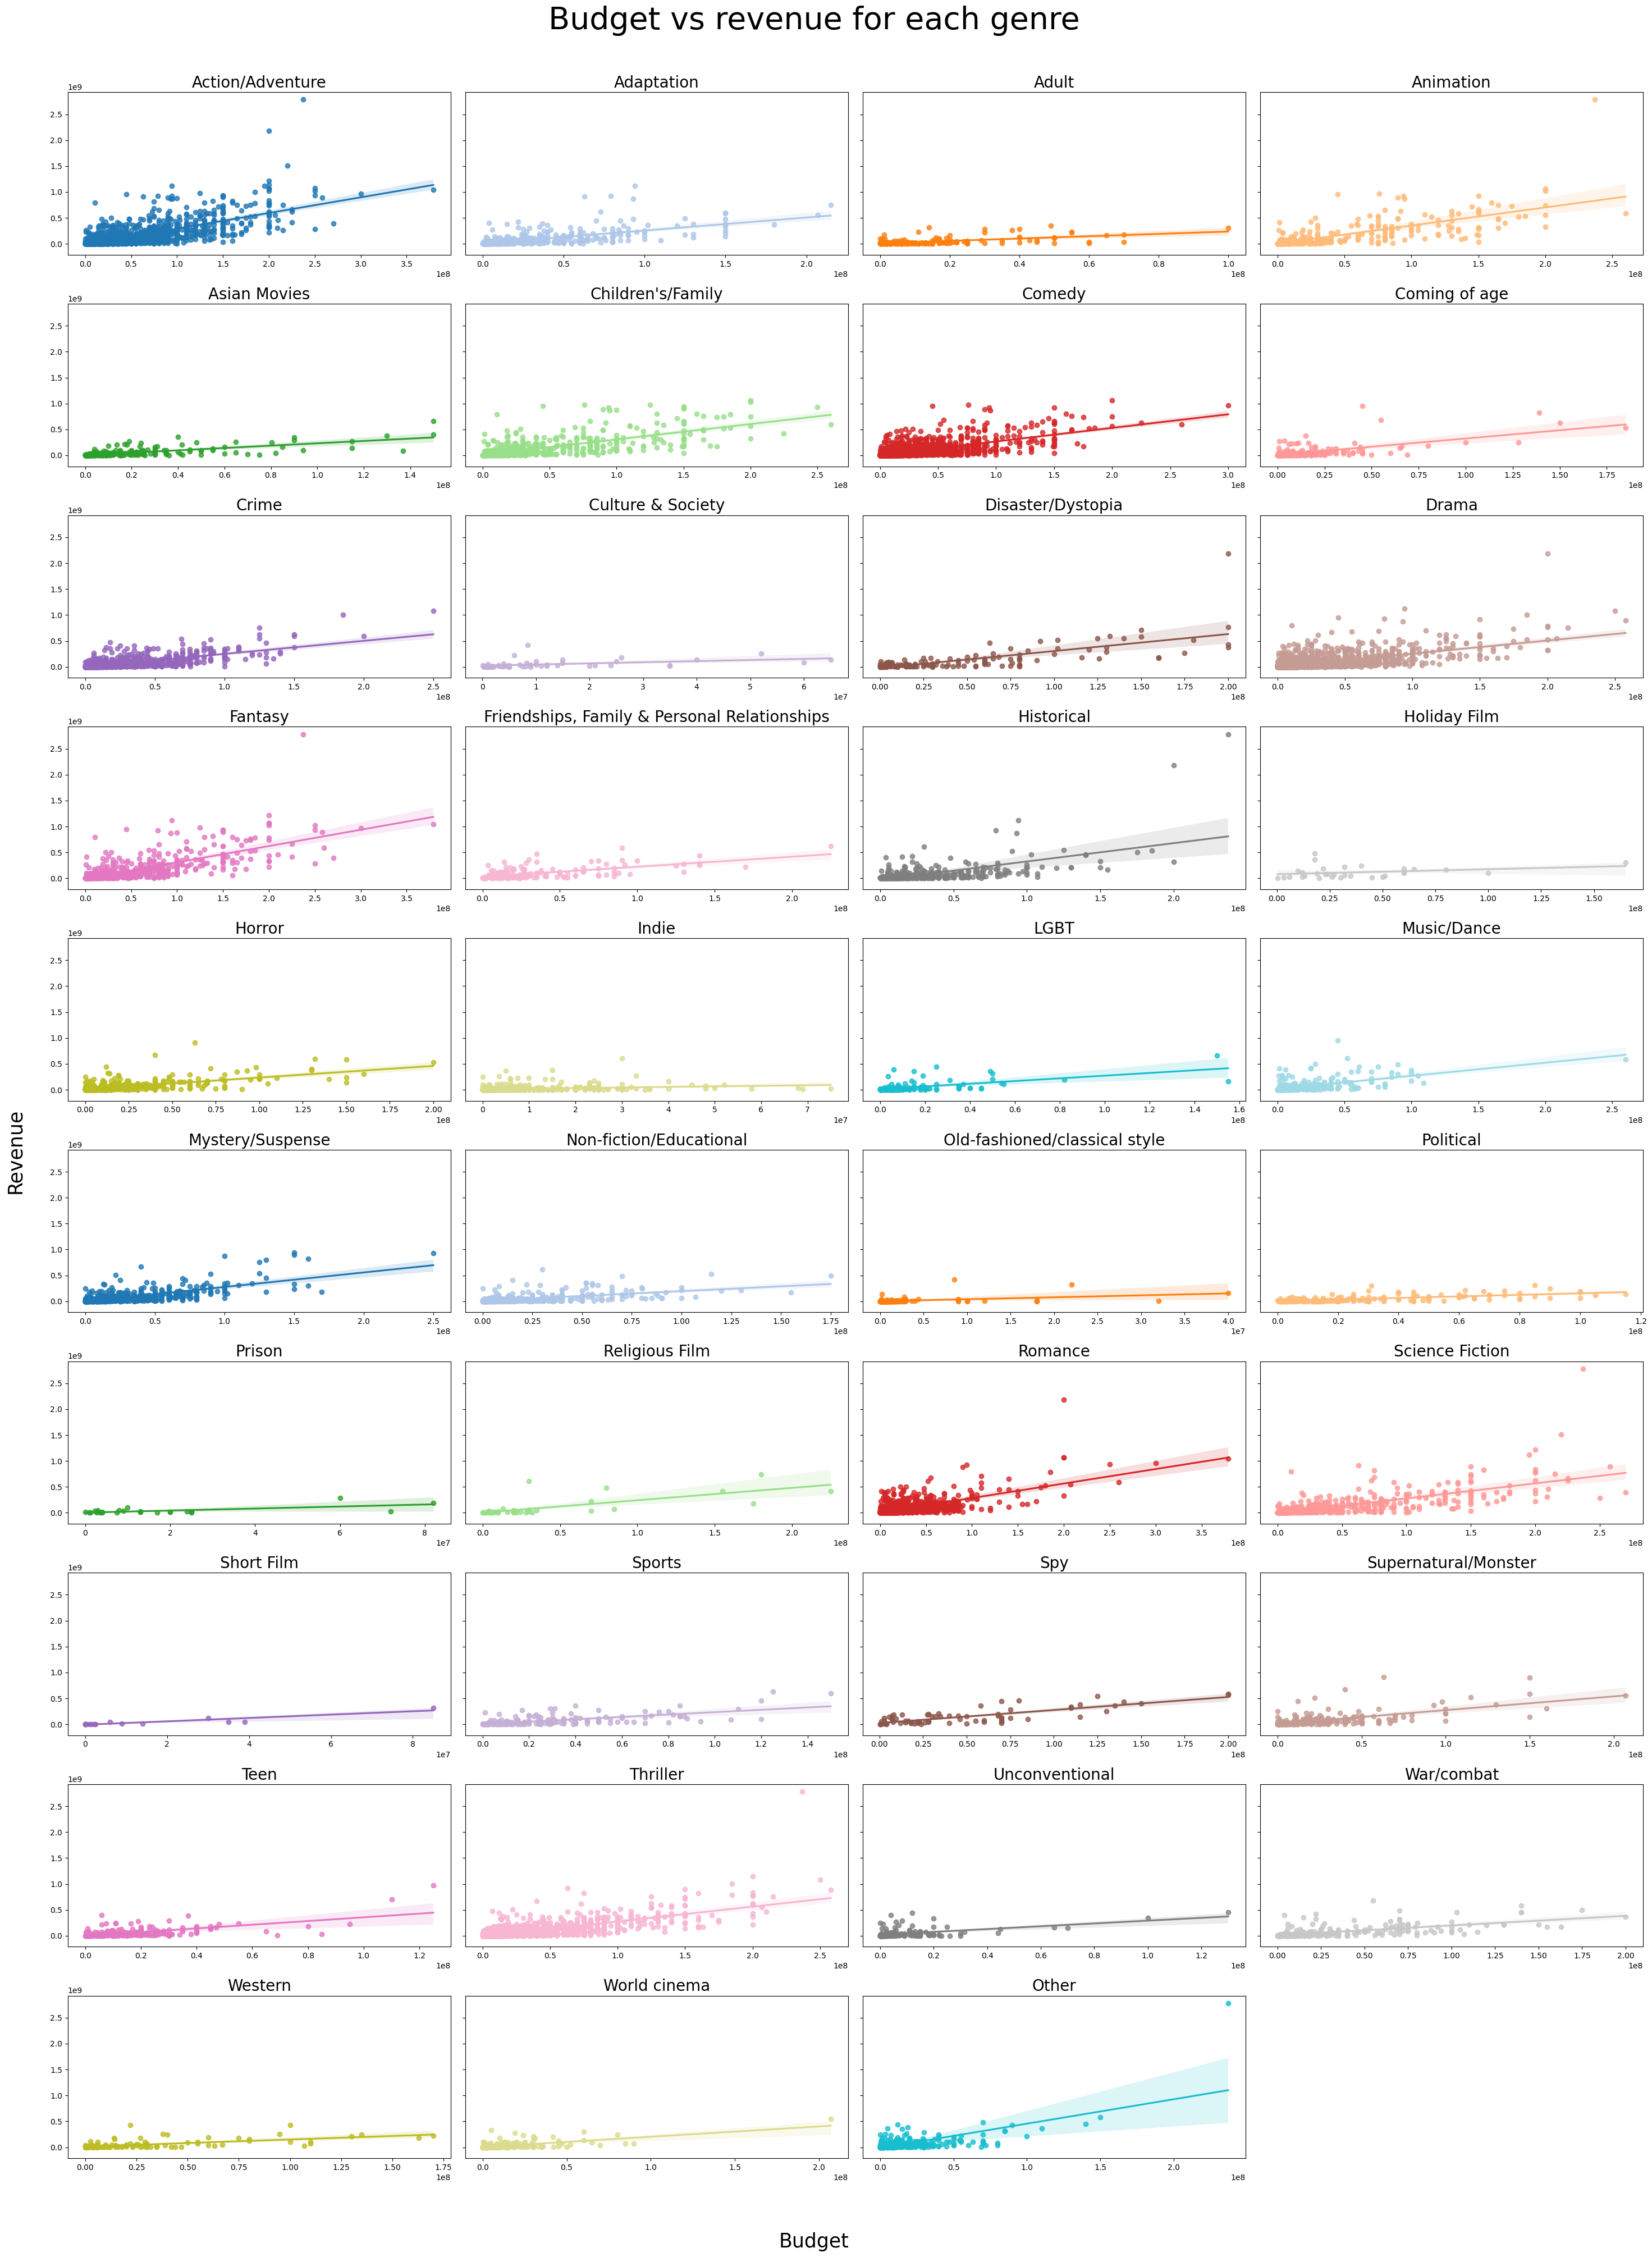

In [162]:
#Plotting budget vs revenue for each genre
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = NEW_GENRE["categories"]

fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
fig.delaxes(axes[9, 3])

colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered = df_filtered[df_filtered['budget'] != 0] #No movies has 0 in budget, so we remove them form the analysis
    df_filtered = df_filtered[df_filtered['revenue'] != 0] #We remove 0 revenue movie, as the lowest recorded box office is 11$ according to Wikipedia
    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.regplot(data=df_filtered, x='budget', y='revenue', color=color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_title(genre, size = 20)
fig.supxlabel('Budget', size = 25)
fig.supylabel('Revenue', size = 25)
fig.suptitle('Budget vs revenue for each genre', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

### HEATMAP (╯°□°)╯︵ ┻━┻

39


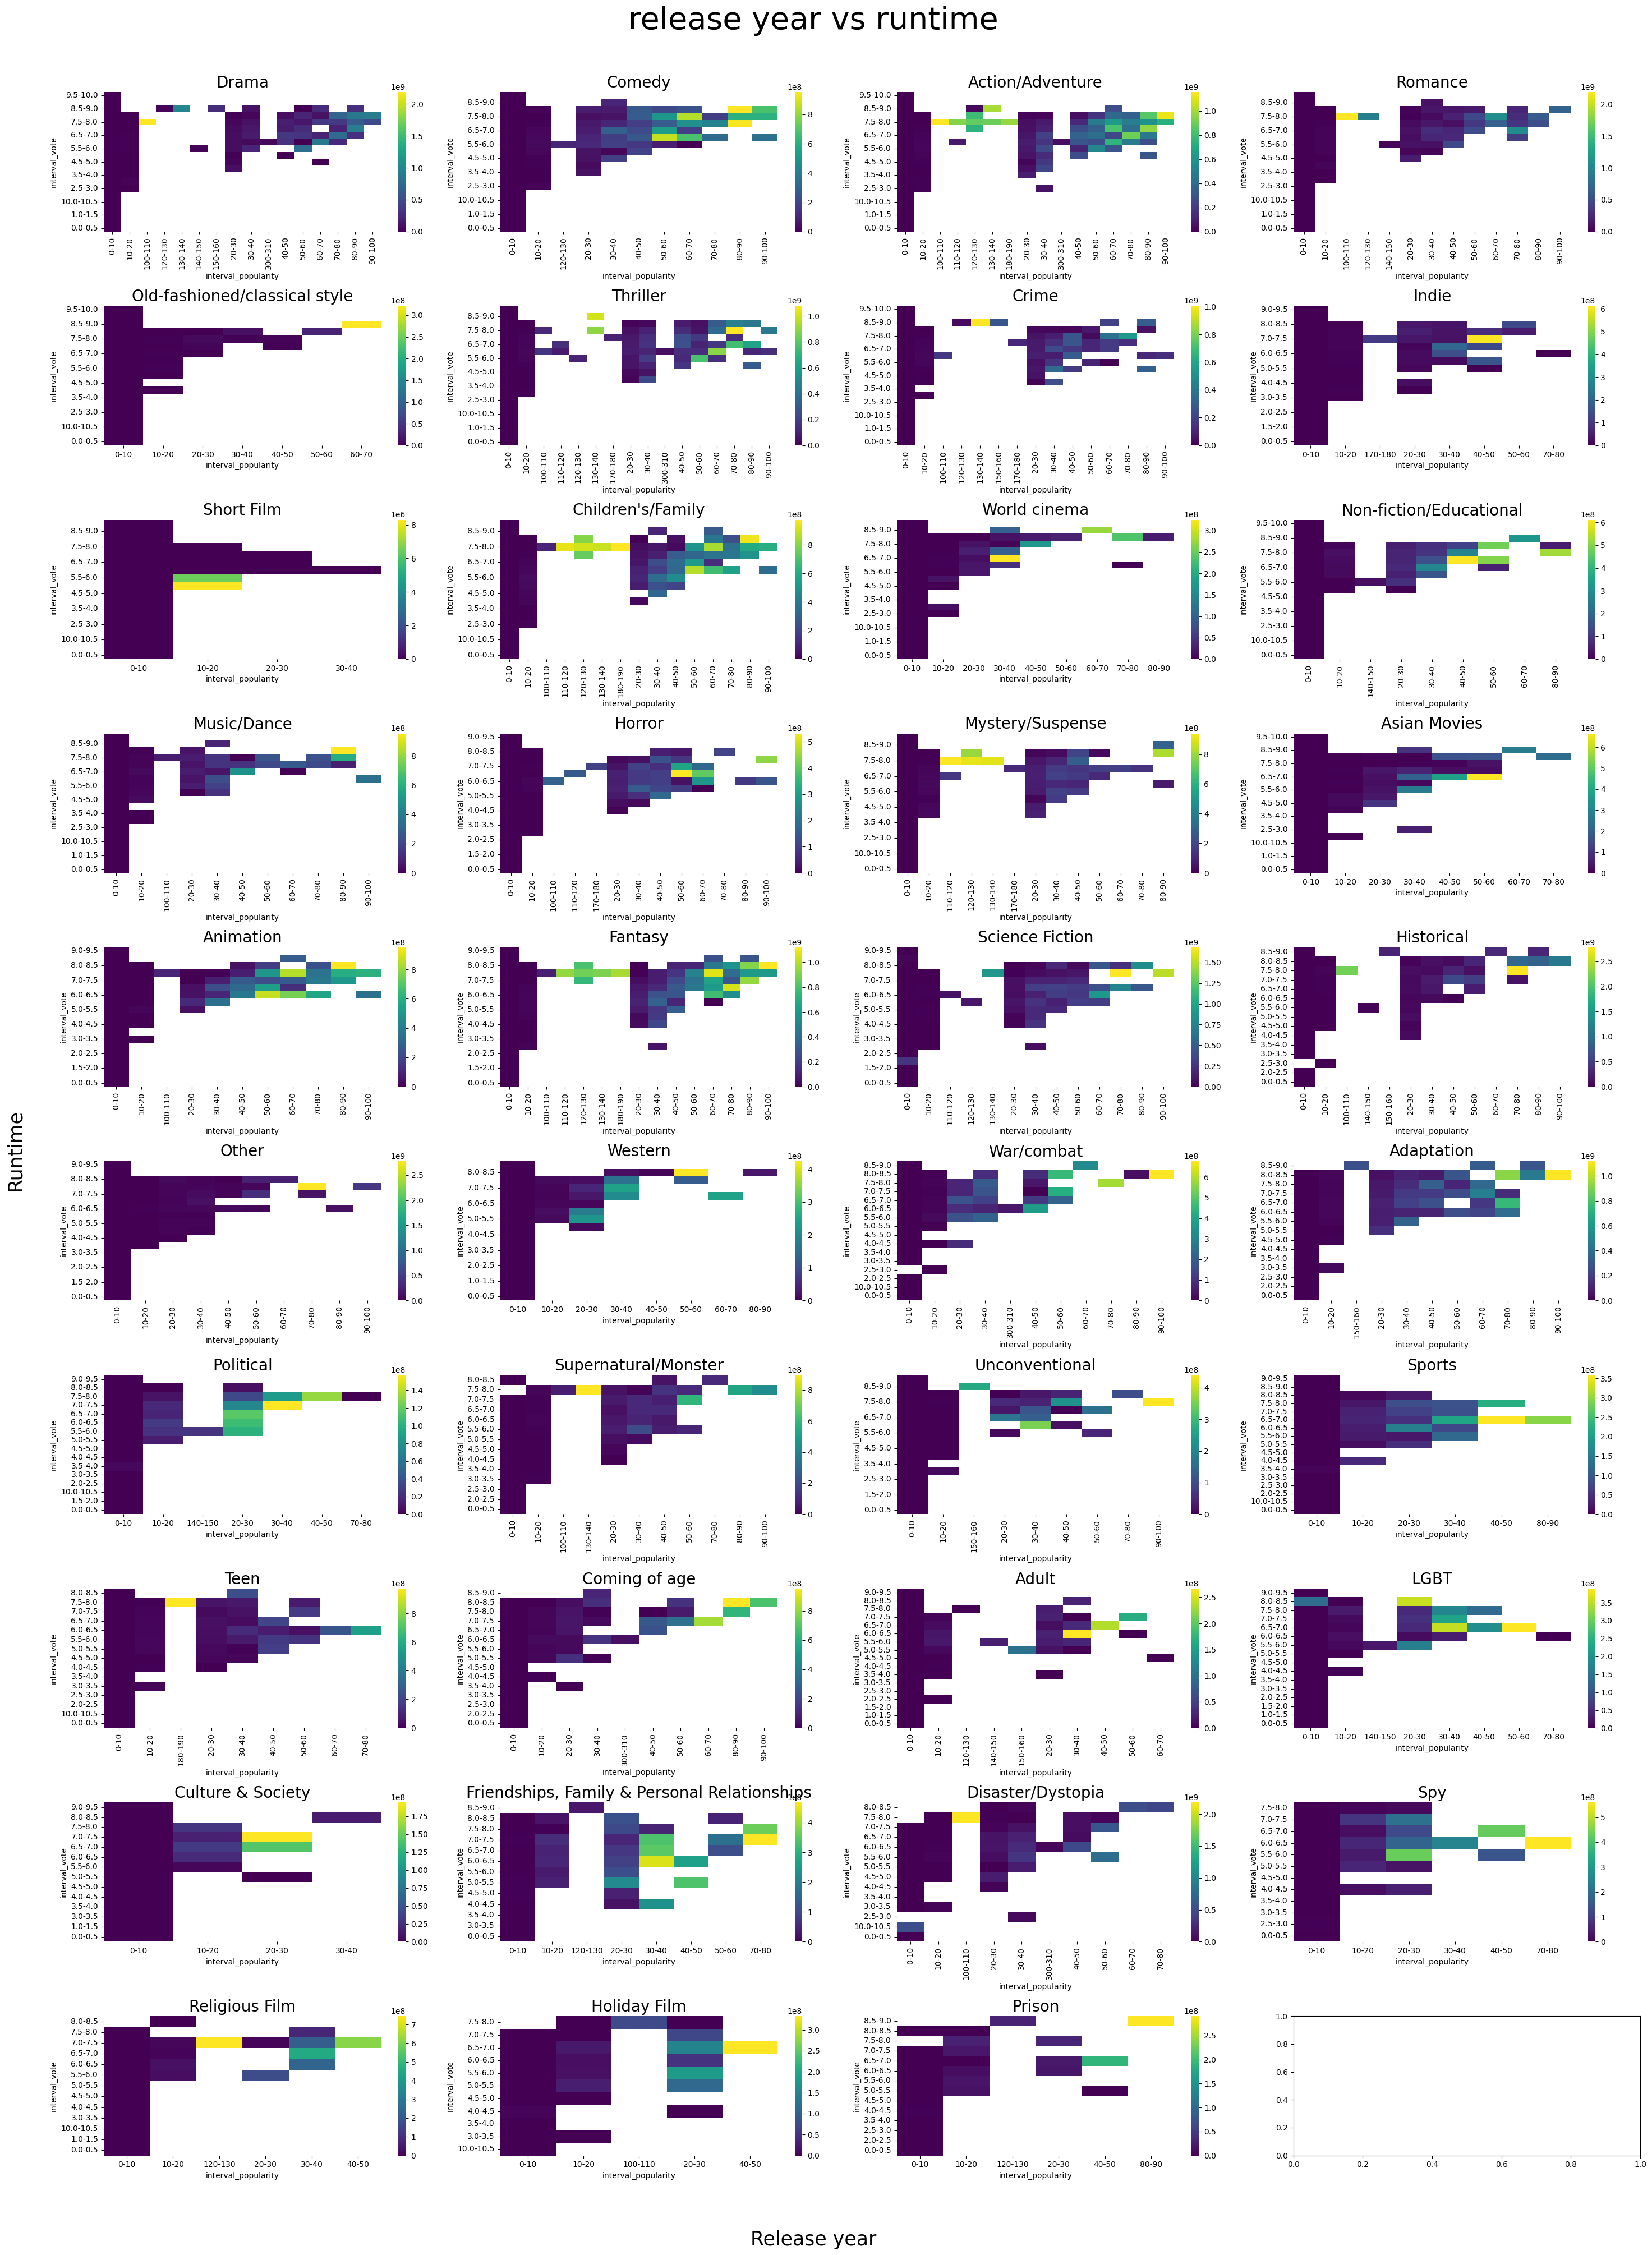

In [163]:
pd.options.mode.chained_assignment = None  # default='warn'

# unique_genre = MOVIES["new_genres"]
unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['interval_vote'] = df_filtered['vote_average'].astype(float).apply(lambda x: f'{int(x/0.5)*0.5}-{int(x/0.5+1)*0.5}')
    df_filtered['interval_popularity'] = df_filtered['popularity'].astype(float).apply(lambda x: f'{int(x/10)*10}-{int(x/10+1)*10}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
    

fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

39


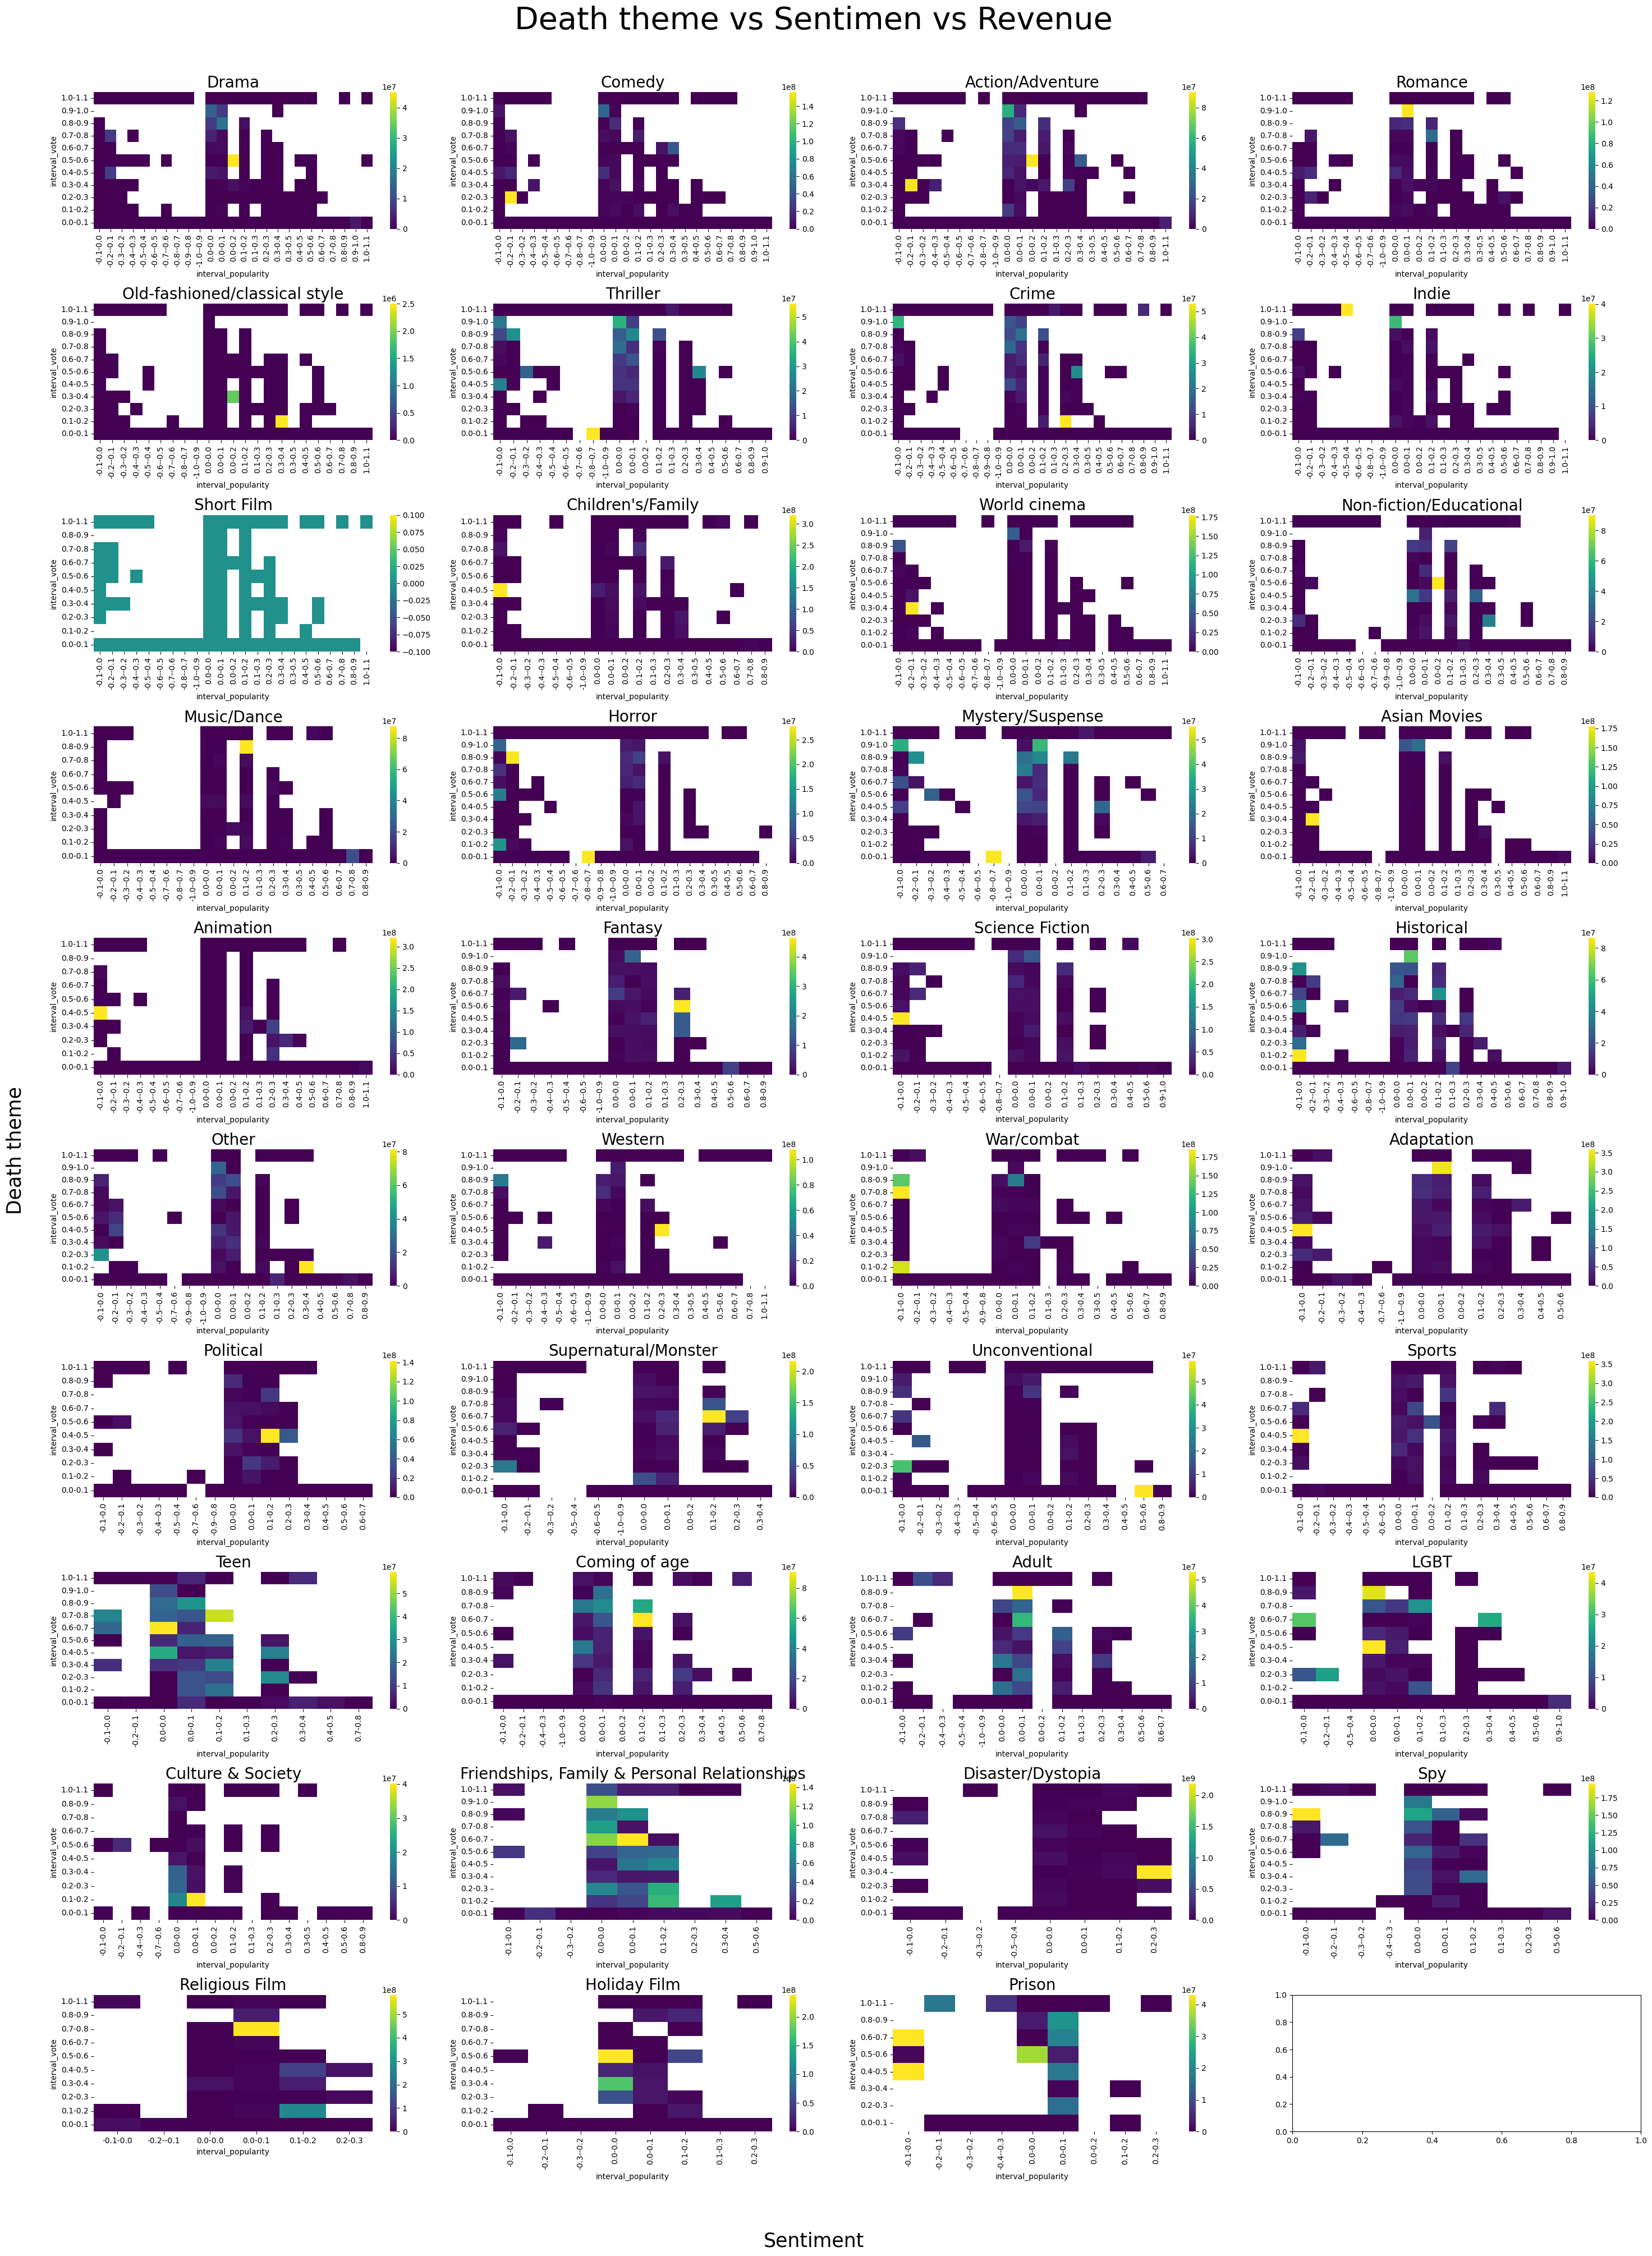

In [164]:
pd.options.mode.chained_assignment = None  # default='warn'

# unique_genre = MOVIES["new_genres"]
unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['interval_vote'] = df_filtered['death'].astype(float).apply(lambda x: f'{int(x/0.1)*0.1:.1f}-{int(x/0.1+1)*0.1:.1f}')
    df_filtered['interval_popularity'] = df_filtered['sentiment'].astype(float).apply(lambda x: f'{int(x/0.1)*0.1:.1f}-{int(x/0.1+1)*0.1:.1f}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
    

fig.supxlabel('Sentiment', size = 25)
fig.supylabel('Death theme', size = 25)
fig.suptitle('Death theme vs Sentimen vs Revenue', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Semtiment makes no different on the revenue but death topics do

# MOVIE GENRE PREDICTOR MODEL

### Data spliting and cross validation definition

In [165]:
def cross_validation_split(data, training_columns, testing_column, set_to_test, train_proportion = 0.2, seed = 42):
    divisions = int(1 / train_proportion)
    if set_to_test is None or set_to_test > divisions or set_to_test < 0:
        print("BE CAREFUL, ONLY VALUES FORM 0 to 1. Setting testing set to 0")
        set_to_test = 0
    # GET THE MOST FROM THE UNBALANCED CLASS
    train_proportion = train_proportion # 1/train_proportion divisioins, as default 2
    n = np.round(train_proportion, 0).astype(int)
        
    data_suffled = data.sample(frac=1, random_state=seed).reset_index(drop=True)
    training_set = data_suffled[:n*set_to_test] + data_suffled[n*(set_to_test+1):] 
    testing_set = data_suffled[n*set_to_test:n*(set_to_test+1)]

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set[training_columns], 
        testing_set[testing_column], 
    )

def train_and_test_split(data, training_columns, testing_column, train_proportion = 0.2, seed = 42):
    training_set, testing_set = train_test_split(data, test_size=train_proportion, random_state=seed)

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set, 
        testing_set[testing_column], 
    )

In [166]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'adult', 'budget', 'popularity', 'plot',
       'original_genres', 'new_genres', 'genre_hot', 'death', 'love',
       'tragedy', 'sentiment', 'Character Count', 'Female actor count',
       'Male actor count', 'N/A actor count', 'Actors 0-20', 'Actors 20-30',
       'Actors 30-40', 'Actors 40-60', 'Actors 60+', 'release_decade'],
      dtype='object')

In [167]:
training_columns = [
    "revenue", "runtime", "release_year",  "vote_average", "vote_count", "adult", "budget", "popularity", "sentiment",
    'death', 'love', 'tragedy', 'Character Count', 'Female actor count', 'Male actor count', 'N/A actor count', 
    'Actors 0-20', 'Actors 20-30', 'Actors 30-40', 'Actors 40-60', 'Actors 60+'
] 
target_column = ["genre_hot"]
training_set, training_target_set, testing_set, testing_target_set = train_and_test_split(MOVIES, training_columns, target_column, train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],seed = SETTINGS["MODEL_SETTINGS"]["SEED"],)

### Model definition

In [168]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid() # To get probabilities
)

### Model instance

In [169]:
feature_size = len(training_columns)
genre_size = len(NEW_GENRE["subgenres"])

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [170]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    f_score_history = []
    precision_history = []
    recall_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        target = target.squeeze(1)
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.float().to(device)
        target = target.float().to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot, correct = get_output_hot(output, target, classification_threshold)
        accuracy = correct.item() / (N * Dy) 
        f_score, precision, recall = compute_avg_f_score(output_hot, target)
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        f_score_history.append(f_score)
        precision_history.append(precision)
        recall_history.append(recall)
        
        del data
        del target
        
        if sample_i % (1000 // N) == 0: # Every 1000 samples
            print(f'Batch {loss_float = :.4f}')
            print(f'Batch {accuracy = :.4f}')
            print(f'Batch {f_score = :.4f}')
            print(f'Batch {precision = :.4f}')
            print(f'Batch {recall = :.4f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    torch.cuda.empty_cache()
    return model, loss_history, accuracy_history, f_score_history, precision_history, recall_history

def get_output_hot(output, target, classification_threshold):
    output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
    correct = torch.sum(output_hot == target)

    return output_hot, correct

def compute_avg_f_score(output_hot, target):
    target = target.int()
    # print(f"{output_hot = }")
    # print(f"{target = }")
    true_positives = torch.sum((output_hot & target), dim = 1)
    false_positives = torch.sum((output_hot & ~target), dim = 1)
    false_negatives = torch.sum((~output_hot & target), dim = 1)
    
    denominator = true_positives + false_positives
    precision = torch.where(denominator > 0,
                            true_positives / denominator,
                            torch.zeros_like(true_positives)
                            )
    
    denominator = true_positives + false_negatives
    recall = torch.where(denominator > 0,
                         true_positives / denominator,
                         torch.zeros_like(true_positives)
                         )
    
    denominator = precision + recall
    f_score = torch.where(denominator > 0,
                          2*(precision * recall) / denominator,
                          torch.zeros_like(true_positives)
                          )
                          
    return torch.mean(f_score).item(), torch.mean(precision).item(), torch.mean(recall).item()

We use stochastic training for better performance. The batch size is 10 by default.

In [171]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        batches_train.append(torch.tensor(training_set.iloc[i:i+batch_size].values, dtype=torch.float64))
        batches_test.append(torch.tensor(target_set.iloc[i:i+batch_size].values.tolist()))
        
    return batches_train, batches_test

In [172]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)
# print(f"{batches_train = }")
# print(f"{batches_test = }")

trained_model, train_loss, train_acc, f_score_history, precision_history, recall_history = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

Batch loss_float = 7.2744
Batch accuracy = 0.5359
Batch f_score = 0.0662
Batch precision = 0.0423
Batch recall = 0.1750
Batch loss_float = 2.4850
Batch accuracy = 0.9256
Batch f_score = 0.2441
Batch precision = 0.4250
Batch recall = 0.1900
Batch loss_float = 7.2922
Batch accuracy = 0.8846
Batch f_score = 0.2175
Batch precision = 0.2543
Batch recall = 0.2283
Batch loss_float = 6.5432
Batch accuracy = 0.8923
Batch f_score = 0.1564
Batch precision = 0.1238
Batch recall = 0.2233
Batch loss_float = 6.2711
Batch accuracy = 0.8949
Batch f_score = 0.0610
Batch precision = 0.0667
Batch recall = 0.0575
Batch loss_float = 5.4888
Batch accuracy = 0.9179
Batch f_score = 0.0733
Batch precision = 0.1000
Batch recall = 0.0583
Batch loss_float = 6.2430
Batch accuracy = 0.9026
Batch f_score = 0.1611
Batch precision = 0.2333
Batch recall = 0.1344
Batch loss_float = 2.9447
Batch accuracy = 0.9308
Batch f_score = 0.0000
Batch precision = 0.0000
Batch recall = 0.0000
Batch loss_float = 4.9901
Batch accuracy

### Training Plotting

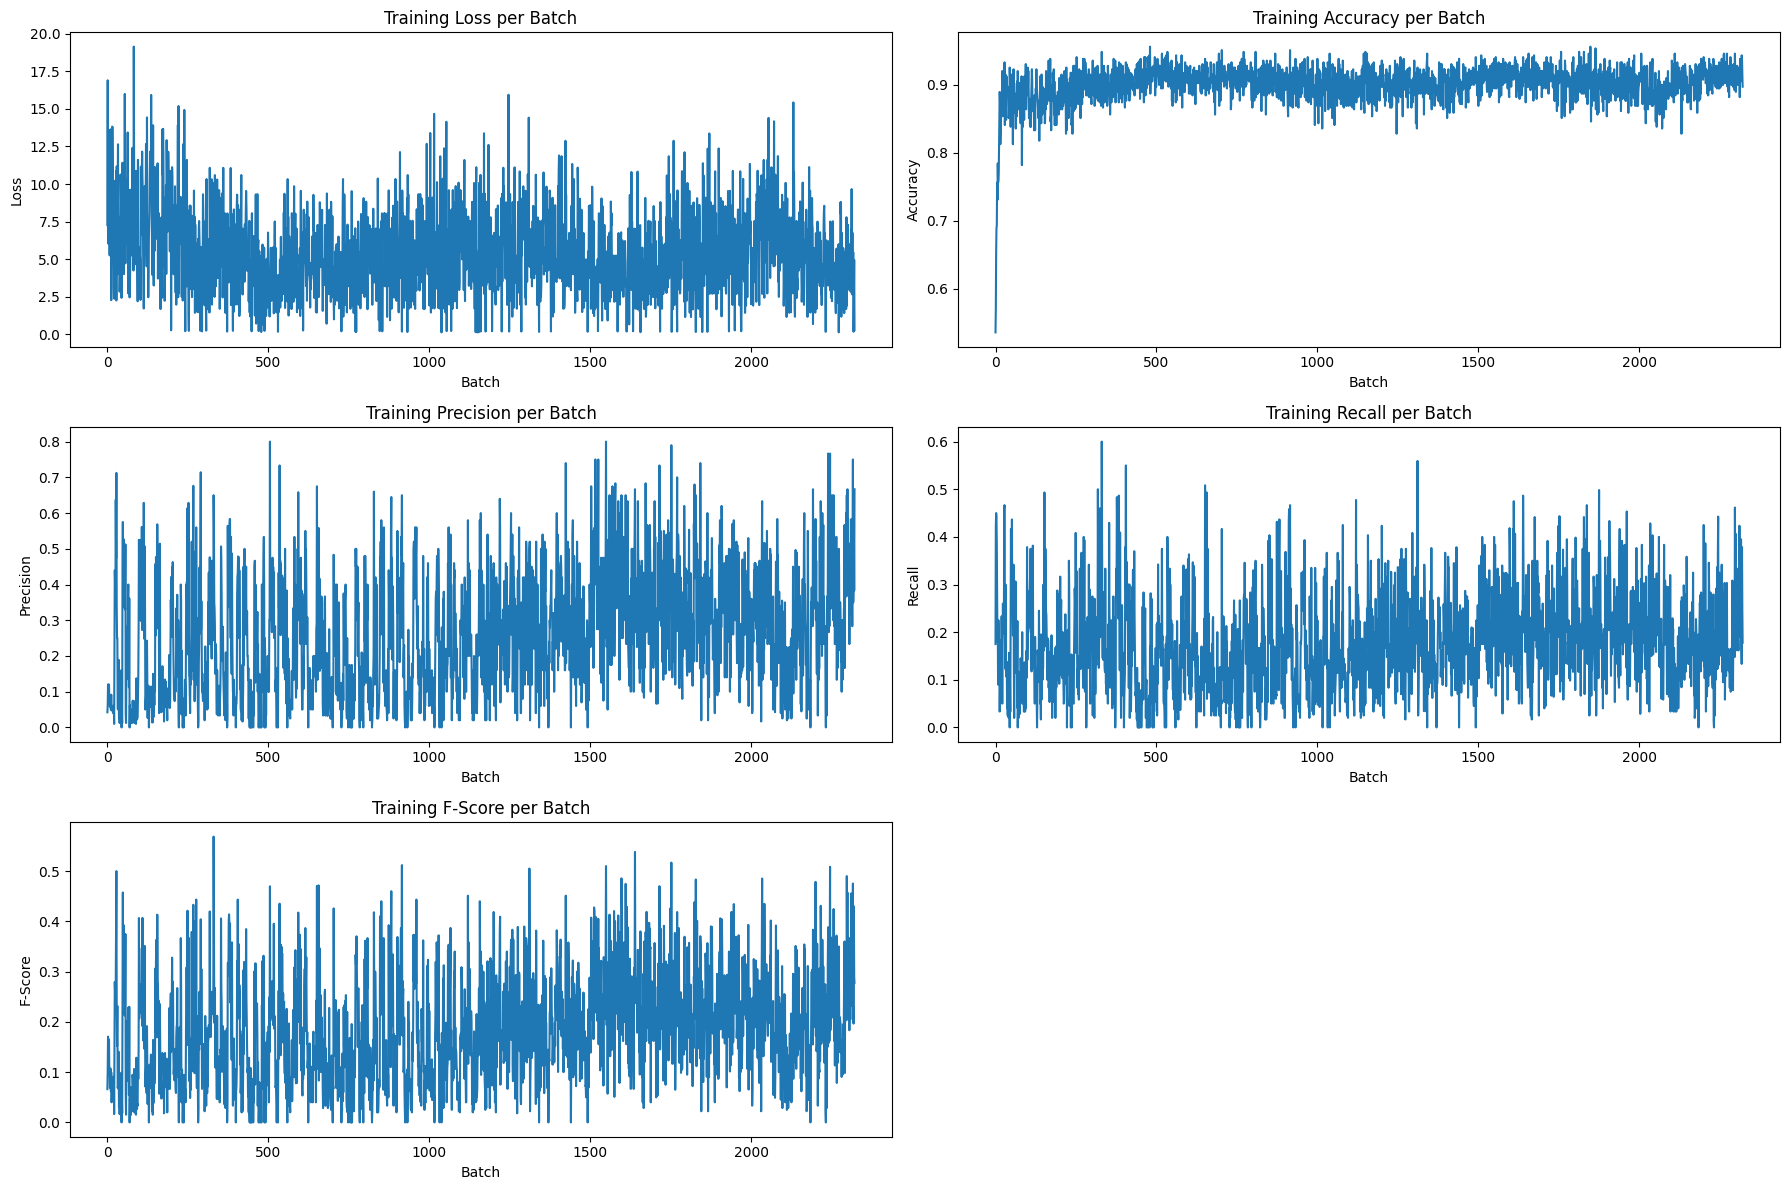

In [173]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(18, 12)) 

plt.subplot(3, 2, 1)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")

plt.subplot(3, 2, 2)
plt.plot(batch_indices, train_acc)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Batch")

plt.subplot(3, 2, 3)
plt.plot(batch_indices, precision_history)
plt.xlabel("Batch")
plt.ylabel("Precision")
plt.title("Training Precision per Batch")

plt.subplot(3, 2, 4)
plt.plot(batch_indices, recall_history)
plt.xlabel("Batch")
plt.ylabel("Recall")
plt.title("Training Recall per Batch")

plt.subplot(3, 2, 5)
plt.plot(batch_indices, f_score_history)
plt.xlabel("Batch")
plt.ylabel("F-Score")
plt.title("Training F-Score per Batch")

plt.tight_layout()
plt.show()

In [174]:
del batches_train
del batches_test
del training_set
del training_target_set
del train_loss
del train_acc
del precision_history
del recall_history
del f_score_history
torch.cuda.empty_cache()

### Model testing

In [175]:
def test_model(model, testing_set, testing_target_set, classification_threshold):
    N = testing_set.shape[0] 
    Dy = testing_target_set.shape[1] 
    
    with torch.no_grad():
        output = model(testing_set)
        
    del testing_set
        
    output_hot, correct = get_output_hot(output, testing_target_set, classification_threshold)
    
    f_score, precision, recall = compute_avg_f_score(output_hot, testing_target_set)
    
    accuracy = correct.item() / (N * Dy) 
    
    print(f'Testing {accuracy = :.4f}')
    print(f'Testing {f_score = :.4f}')
    print(f'Testing {precision = :.4f}')
    print(f'Testing {recall = :.4f}')
    
    return output_hot
    

In [176]:
testing_set_t = torch.tensor(testing_set[training_columns].values.tolist(), dtype=torch.float32).to(device_cpu)
testing_target_set_t = torch.tensor(testing_target_set.values.tolist(), dtype=torch.float32).to(device_cpu)
trained_model = trained_model.to(device_cpu)

predictions = test_model(trained_model, testing_set_t, testing_target_set_t, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = NEW_GENRE["categories"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

# predictions_df = pd.DataFrame(predictions, columns=genre_labels)
# predicted_genre = predictions_df.apply(
#     lambda row: [genre for genre, is_genre in zip(genre_labels, row) if is_genre == 1],
#     axis=1
# ).tolist()

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'original_genres': testing_set["new_genres"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


Testing accuracy = 205997.7602
Testing f_score = 0.0146
Testing precision = 0.0476
Testing recall = 0.0123
